In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sys import version_info
import pickle
import mlflow
import cloudpickle

from tqdm import tqdm

from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap

from kmodes.kprototypes import KPrototypes

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
song_df = pd.read_csv('SpotifyFeatures.csv')
song_df = song_df[(song_df['genre'] != """Children's Music""")]
song_df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.6110,0.3890,99373,0.9100,0.0000,C#,0.3460,-1.8280,Major,0.0525,166.9690,4/4,0.8140
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.2460,0.5900,137373,0.7370,0.0000,F#,0.1510,-5.5590,Minor,0.0868,174.0030,4/4,0.8160
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.9520,0.6630,170267,0.1310,0.0000,C,0.1030,-13.8790,Minor,0.0362,99.4880,5/4,0.3680
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.7030,0.2400,152427,0.3260,0.0000,C#,0.0985,-12.1780,Major,0.0395,171.7580,4/4,0.2270
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.9500,0.3310,82625,0.2250,0.1230,F,0.2020,-21.1500,Major,0.0456,140.5760,4/4,0.3900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.0038,0.6870,326240,0.7140,0.5440,D,0.0845,-10.6260,Major,0.0316,115.5420,4/4,0.9620
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.0329,0.7850,282447,0.6830,0.0009,E,0.2370,-6.9440,Minor,0.0337,113.8300,4/4,0.9690
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.9010,0.5170,166960,0.4190,0.0000,D,0.0945,-8.2820,Major,0.1480,84.1350,4/4,0.8130
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.2620,0.7450,222442,0.7040,0.0000,A,0.3330,-7.1370,Major,0.1460,100.0310,4/4,0.4890


In [3]:
song_df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,"227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000","227,322.0000"
mean,42.0039,0.3633,0.5510,"237,318.4014",0.5751,0.1484,0.2162,-9.5206,0.1208,117.5842,0.4497
std,17.4395,0.3540,0.1849,"118,897.1779",0.2633,0.3027,0.1993,6.0240,0.1860,30.9051,0.2582
min,0.0000,0.0000,0.0569,"15,509.0000",0.0000,0.0000,0.0097,-52.4570,0.0222,30.3790,0.0000
25%,30.0000,0.0356,0.4320,"185,078.5000",0.3930,0.0000,0.0976,-11.6470,0.0367,92.7510,0.2340
50%,44.0000,0.2230,0.5670,"221,736.0000",0.6120,0.0000,0.1290,-7.6800,0.0500,115.6000,0.4380
75%,55.0000,0.7140,0.6880,"267,000.0000",0.7900,0.0365,0.2660,-5.4640,0.1050,139.1105,0.6530
max,100.0000,0.9960,0.9870,"5,552,917.0000",0.9990,0.9990,1.0000,3.7440,0.9670,242.9030,1.0000


In [4]:
song_df.describe(include=['O'])

,genre,artist_name,track_name,track_id,key,mode,time_signature
count,227322,227322,227322,227322,227322,227322,227322
unique,26,14400,144676,171372,12,2,5
top,Comedy,Giuseppe Verdi,Home,3uSSjnDMmoyERaAK9KvpJR,C,Major,4/4
freq,9681,1394,100,8,26604,147036,196298


In [5]:
song_info = song_df.iloc[:,0:4].copy().drop_duplicates()
song_attributes = song_df.iloc[:,3:].copy().drop_duplicates()

In [6]:
song_unique = song_attributes.copy().reset_index(drop=True)
song_unique['rank'] = song_unique.groupby('track_id')['popularity'].rank(ascending=False)
song_unique = song_unique[(song_unique['rank']==1)].drop(['rank'],axis=1)
song_track = song_unique.iloc[:,0]
song_features = song_unique.iloc[:,1:]

In [7]:
song_unique.describe(include=['O'])

,track_id,key,mode,time_signature
count,171370,171370,171370,171370
unique,171370,12,2,5
top,0BRjO6ga9RKCKjfDqeFgWV,C,Major,4/4
freq,1,19990,111912,144724


In [8]:
def float_table(df):
    for x in df.columns:
        try:
            df[x] = df[x].astype(np.float64)
        except:
            pass
    return df

In [9]:
ct = ColumnTransformer([("scale", QuantileTransformer(output_distribution='normal'), song_features.select_dtypes(exclude='object').columns),],remainder="drop",verbose=True,verbose_feature_names_out=False)
song_scale = float_table(pd.DataFrame(ct.fit_transform(song_features),columns=ct.get_feature_names_out()))
song_scale

[ColumnTransformer] ......... (1 of 1) Processing scale, total=   0.9s


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-5.1993,0.4143,-0.7748,-1.7166,1.2896,-5.1993,0.9185,2.4156,0.0980,1.3595,1.2475
1,-2.0431,-0.0464,0.1893,-1.2735,0.4612,-5.1993,0.1702,0.6838,0.5761,1.6342,1.2585
2,-1.9029,1.2983,0.5895,-0.8423,-1.2867,-5.1993,-0.5409,-0.7943,-0.7250,-0.3937,-0.1855
3,-5.1993,0.5293,-1.3781,-1.0895,-0.7414,-5.1993,-0.6580,-0.6102,-0.4710,1.5214,-0.6364
4,-1.8448,1.2838,-1.0062,-1.9218,-0.9897,0.7045,0.4225,-1.4182,-0.1359,0.7646,-0.1157
...,...,...,...,...,...,...,...,...,...,...,...
171365,0.2953,-0.9938,-1.1546,0.5339,0.4696,0.3977,0.0703,0.2080,-0.2381,1.7621,2.0265
171366,-0.3295,0.3629,-0.6272,-1.1886,-0.7120,-5.1993,0.6580,-0.7102,-0.2304,-1.2038,0.1855
171367,0.0113,-0.7480,1.3621,0.8002,0.2614,0.2380,0.5409,0.2638,-0.9575,-0.0246,2.6965
171368,0.5207,1.0272,-0.1893,-0.8919,-0.5149,-5.1993,-0.7614,-0.0369,0.8958,-0.9750,1.2421


In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(song_tnse.iloc[:,0],song_tnse.iloc[:,1], s=2, cmap='tab20b', alpha=1.0)
plt.show()

In [13]:
songs_umap = umap.UMAP(metric='l2',n_components=3,min_dist=.25).fit_transform(song_scale)

In [14]:
songs_umap

array([[11.881619  ,  0.6905132 ,  4.8429594 ],
       [ 6.0583305 , 11.080432  ,  5.8261304 ],
       [ 6.3780317 ,  9.629614  ,  3.8268821 ],
       ...,
       [-2.4135728 , -0.07880375,  3.2870803 ],
       [ 4.9603214 ,  8.912354  ,  5.417364  ],
       [-3.8290598 ,  1.2541641 ,  4.747229  ]], dtype=float32)

In [24]:
metrics = ['euclidean','manhattan','chebyshev','minkowski','canberra','braycurtis','mahalanobis','l2']

6it [2:03:36, 1717.23s/it]/usr/local/lib/python3.9/site-packages/pynndescent/pynndescent_.py:906: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
8it [2:07:17, 954.63s/it]


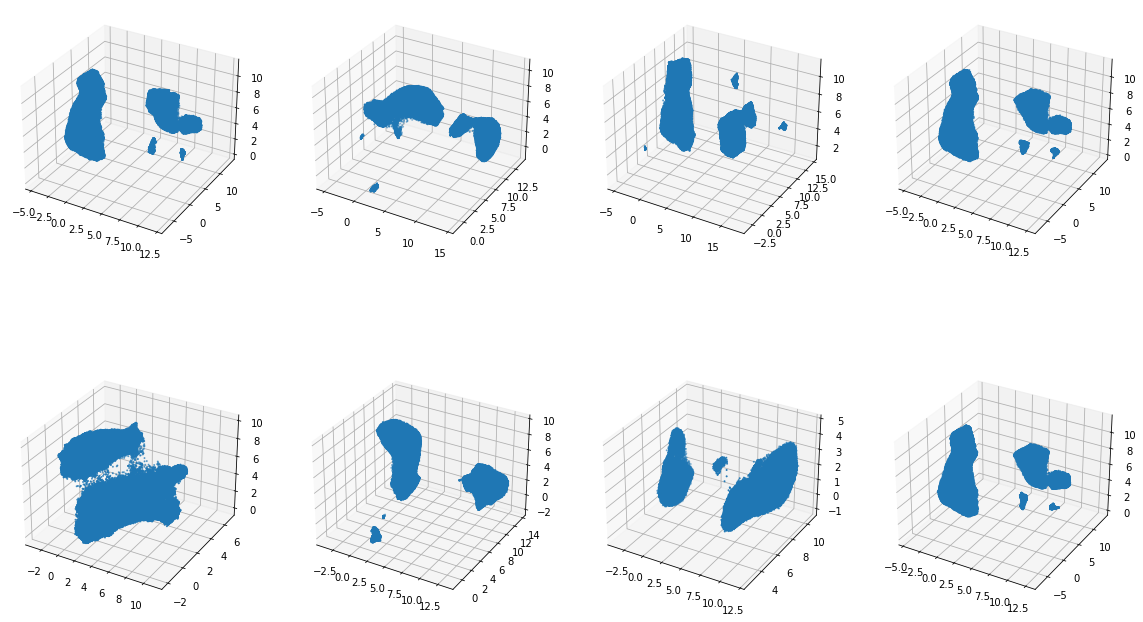

In [26]:
fig = plt.figure(figsize=(20, 12))

for i, metric in tqdm(enumerate(metrics)):
    songs_umap = umap.UMAP(metric=metric,n_components=3,min_dist=.25).fit_transform(song_scale)

    ax = fig.add_subplot(2,4,i+1,projection='3d')
    ax.scatter(songs_umap[:,0], songs_umap[:,1], songs_umap[:,2], s=1, cmap='tab20b')
plt.show()

In [ ]:
categorical_columns = [i for i,x in enumerate(song_scale.columns) if x in song_scale.select_dtypes(include='object').columns]

In [ ]:
categorical_columns

In [ ]:
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
kprotoModel = kproto.fit(song_scale, categorical=categorical_columns)
clusters = kprotoModel.predict(song_scale)

In [ ]:
#mlflow.set_tracking_uri("databricks")
#mlflow.set_experiment("/Users/connor.mccambridge@sprint.com/Medium/K-Prototype")

In [ ]:
inits = ['Huang','Cao','random']
ns = range(1,20)
params = [(x,y) for x in inits for y in ns]

In [ ]:
PYTHON_VERSION = "{major}.{minor}.{micro}".format(major=version_info.major,minor=version_info.minor,micro=version_info.micro)

conda_env = {
    'channels': ['defaults'],
    'dependencies': [
      'python={}'.format(PYTHON_VERSION),
      'pip',
      {
        'pip': [
          'mlflow',
          'kproto=={}'.format(kproto.__version__),
          'cloudpickle=={}'.format(cloudpickle.__version__),
        ],
      },
    ],
    'name': 'kproto_env'
}

In [ ]:
import mlflow.pyfunc
class kprotoWrapper(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        import pickle
        self.kproto_model = pickle.load(open(context.artifacts["kproto_model"], "rb" ))

    def predict(self, context, model_input):
        return self.kproto_model.predict(model_input)

In [ ]:
with mlflow.start_run():

    kproto_model_path = "model.kproto"

    pickle.dump(kprotoModel, open(kproto_model_path, "wb" ))

    artifacts = {
        "kproto_model": kproto_model_path
    }

    mlflow_pyfunc_model_path = "kproto_mlflow_pyfunc"
    mlflow.pyfunc.save_model(path=mlflow_pyfunc_model_path, python_model=kprotoWrapper(), artifacts=artifacts)

    mlfow.end_run()